In [15]:
import pymysql
import datetime
import time
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

# import sys
# sys.path.append(r'C:\Users\10768\personal files\waiting_time\waiting_time_project\my_tools')
# import tools_for_os.for_df as ml_df
# import tools_for_os.for_file as ml_fl

import sys
sys.path.append(r'C:\Users\10768\personal files\waiting_time\waiting_time_project')
from utils.funcs import read_df_from_sql
from utils.logger import logger
from data_process import get_apptointment_info, get_treat_info
from wtp.duration.predict_sequence_model_v1 import combine_mul_row_appt, combine_mul_row_treat,\
    one_hot_enc, process_sequence_data, filter_data, NN_NUM_FEATURES
from wtp.duration.predict_lgb_model import CATE_FEATURES

# 1 Process Data

In [2]:
processed_appointment_data = get_apptointment_info()
print(f'process_appointment_data shap {processed_appointment_data.shape}')
processed_treatment_data = get_treat_info()
print(f'processed_treatment_data shap {processed_treatment_data.shape}')

WAITING TIME: 2020-08-19 10:22:13 [INFO] Get information about appointment!
WAITING TIME: 2020-08-19 10:22:13 [DEBUG] Get table of appointment!
WAITING TIME: 2020-08-19 10:22:58 [DEBUG] Get table of patient!
WAITING TIME: 2020-08-19 10:22:59 [DEBUG] Merge appointment and patient!
WAITING TIME: 2020-08-19 10:22:59 [DEBUG] Get table of patientdoctor!
WAITING TIME: 2020-08-19 10:23:02 [DEBUG] Merge patientdoctor!
WAITING TIME: 2020-08-19 10:23:02 [DEBUG] Get table of diagnosis!
WAITING TIME: 2020-08-19 10:23:03 [DEBUG] Get table of diagnosis!
WAITING TIME: 2020-08-19 10:23:03 [DEBUG] Merge diagnosis and diagnosistranslation!
WAITING TIME: 2020-08-19 10:23:04 [DEBUG] Get table of course!
WAITING TIME: 2020-08-19 10:23:05 [DEBUG] Get table of plan!
WAITING TIME: 2020-08-19 10:23:09 [DEBUG] Merge plan and course!
WAITING TIME: 2020-08-19 10:23:10 [DEBUG] Merge plan_course and appointment!
WAITING TIME: 2020-08-19 10:23:11 [DEBUG] Drop columns with same values!
WAITING TIME: 2020-08-19 10:23:

process_appointment_data shap (859231, 21)


WAITING TIME: 2020-08-19 10:26:08 [DEBUG] Get table of radiationhstry!
WAITING TIME: 2020-08-19 10:27:24 [DEBUG] Merge radiation and radiationhstry!
WAITING TIME: 2020-08-19 10:27:25 [DEBUG] Merge plan!
WAITING TIME: 2020-08-19 10:27:30 [DEBUG] Get table of radiation!
WAITING TIME: 2020-08-19 10:27:31 [DEBUG] Get table of radiation!
WAITING TIME: 2020-08-19 10:27:32 [DEBUG] Merge course and patient
WAITING TIME: 2020-08-19 10:27:32 [DEBUG] Merge radiation and radiation!
WAITING TIME: 2020-08-19 10:27:33 [DEBUG] Drop columns with same values!
WAITING TIME: 2020-08-19 10:27:34 [DEBUG] Process treatment data!


processed_treatment_data shap (507863, 15)


In [71]:
processed_data = pd.merge(processed_appointment_data, processed_treatment_data,
                          on=['PatientSerNum', 'date'], how='inner')

In [73]:
processed_seq_data = process_sequence_data(processed_data)
_, _, series_data = filter_data(processed_seq_data)

# 进行one hot 编码
label_encoder_dxt_AliasName = one_hot_enc('dxt_AliasName', processed_seq_data)
label_encoder_Sex = one_hot_enc('Sex', processed_seq_data)
label_encoder_AliasSerNum = one_hot_enc('AliasSerNum', processed_seq_data)
label_encoder_month = one_hot_enc('month', processed_seq_data)
label_encoder_week = one_hot_enc('week', processed_seq_data)
label_encoder_hour = one_hot_enc('hour', processed_seq_data)
label_encoder_DoctorSerNum = one_hot_enc('DoctorSerNum', processed_seq_data)
label_encoder_TreatmentOrientation = one_hot_enc('TreatmentOrientation', processed_seq_data)
label_encoder_FractionNumber = one_hot_enc('FractionNumber', processed_seq_data)
label_encoder_UserName = one_hot_enc('UserName', processed_seq_data)
label_encoder_CourseId = one_hot_enc('CourseId', processed_seq_data)
label_encoder_ResourceSerNum = one_hot_enc('ResourceSerNum', processed_seq_data)

WAITING TIME: 2020-08-19 14:08:02 [INFO] Process sequence data!
WAITING TIME: 2020-08-19 14:08:08 [INFO] Combine Appointment with multiple rows!
WAITING TIME: 2020-08-19 14:08:08 [INFO] Start processing categorical features!
WAITING TIME: 2020-08-19 14:08:08 [DEBUG] PatientSerNum
WAITING TIME: 2020-08-19 14:08:16 [DEBUG] Sex
WAITING TIME: 2020-08-19 14:08:32 [DEBUG] DoctorSerNum
WAITING TIME: 2020-08-19 14:08:49 [DEBUG] date
WAITING TIME: 2020-08-19 14:08:58 [DEBUG] ScheduledStartTime
WAITING TIME: 2020-08-19 14:09:06 [DEBUG] ScheduledEndTime
WAITING TIME: 2020-08-19 14:09:14 [DEBUG] ActualStartDate
WAITING TIME: 2020-08-19 14:09:22 [DEBUG] ActualEndDate
WAITING TIME: 2020-08-19 14:09:31 [DEBUG] dxt_AliasName
WAITING TIME: 2020-08-19 14:09:47 [DEBUG] AliasSerNum
WAITING TIME: 2020-08-19 14:10:06 [DEBUG] CourseSerNum
WAITING TIME: 2020-08-19 14:10:14 [DEBUG] PlanSerNum
WAITING TIME: 2020-08-19 14:10:23 [DEBUG] TreatmentOrientation
WAITING TIME: 2020-08-19 14:10:38 [DEBUG] month
WAITING 

# 2 Generate room samples

In [74]:
logger.debug('Get room information!')
data_re_appt = read_df_from_sql('SELECT * FROM resourceappointment').drop(columns=['LastUpdated'])
print(f'\nThe shape of data_re_appt {data_re_appt.shape}')

data_room = data_re_appt.rename(columns = {'ResourceSerNum': 'room'})
data_room = data_room[['AppointmentSerNum', 'room']].drop_duplicates()
print(f'The shape of data_room {data_room.shape}')

room_series_data = pd.merge(series_data, data_room, on = 'AppointmentSerNum', how = 'left')
print(f'The shape of room_series_data {room_series_data.shape}')

WAITING TIME: 2020-08-19 14:12:47 [DEBUG] Get room information!



The shape of data_re_appt (475920, 6)
The shape of data_room (475864, 2)
The shape of room_series_data (143297, 30)


In [75]:
ROOM_NUM_FEATURES = ['Scheduled_duration', 'age', 'TreatmentTime_total',
                     'ImagesTaken_total', 'MU_total', 'MUCoeff_total', 'order',
                     'last_Scheduled_duration', 'last_age', 'last_TreatmentTime_total',
                     'last_ImagesTaken_total', 'last_MU_total', 'last_MUCoeff_total', 'last_order',
                     'Interval_number', 'Transfer_duration']
# 'last_Actual_duration', 'Actual_duration'

ROOM_CATE_FEATURES = ['dxt_AliasName', 'Sex', 'AliasSerNum', 'hour', 'DoctorSerNum',
                      'TreatmentOrientation', 'FractionNumber', 'UserName', 'CourseId',
                      'last_dxt_AliasName', 'last_Sex', 'last_AliasSerNum', 'last_hour', 'last_DoctorSerNum',
                      'last_TreatmentOrientation', 'last_FractionNumber', 'last_UserName', 'last_CourseId',
                      'ResourceSerNum', 'month', 'week']

# 还可以增加AliasExpressionSerNum

In [76]:
# 计算时间差
def cal_time_inv(before, now):
#     before = str_to_Datetime(before)
#     now = str_to_Datetime(now)
    if now >= before:
        inv = (now - before).seconds
        return inv
    else:
        return 0

In [80]:
def get_room_last_future_patient(room_info_grouped, room_number):
    room = room_info_grouped.get_group(room_number)
    
    room = room.sort_values(by = 'ScheduledStartTime')
    room['order'] = [i+1 for i in range(room.shape[0])]
    
    room = room.sort_values(by = 'ActualStartDate').reset_index(drop = True)
    
    # 去掉最后一位患者的信息，构成上一位患者的DataFrame
    room_last = room.copy()
    room_last = room_last.drop(labels = [room_last.index[-1]], axis = 0).reset_index(drop = True)
    room_last.columns = ['last_' + col for col in room_last.columns]
    
    # 去掉第一位患者的信息，构成当前患者的DataFrame
    room = room.drop(labels = [room.index[0]], axis = 0).reset_index(drop = True)
    
    # 横向拼接数据
    room = pd.concat([room_last, room], axis = 1)
    
    # 计算实际转换时长，也就是得到标签
    room['Transfer_duration'] = room.apply(lambda x: 
                                           cal_time_inv(x.last_ActualEndDate, x.ActualStartDate) / 60, axis = 1)
    
    # 因为可能有缺失的数据，因此把这个作为一个特征
    room['Interval_number'] = room.apply(lambda x: int(x.Transfer_duration / 15), axis = 1)
    
    room = room[ROOM_NUM_FEATURES + ROOM_CATE_FEATURES]
    
    return room

In [81]:
room_info_grouped = room_series_data.groupby(['room', 'date'])

room_count = room_info_grouped.count()
room_seq = room_count[room_count.PatientSerNum > 1].index.tolist()
room_one = room_count[room_count.PatientSerNum == 1].index.tolist()
print(f'room_seq {len(room_seq)}')
print(f'room_one {len(room_one)}')

room_seq 6730
room_one 521


In [87]:
# 形成专门针对room 的DataFrame
print('Get DataFrame for room')
room_sample_all = pd.DataFrame({})
for i in range(len(room_seq)):
    if (i+1) % 100 == 0:
        print(f'No.{i+1} Room samples')
    room_number = room_seq[i]
    room = get_room_last_future_patient(room_info_grouped, room_number)
    room_sample_all = pd.concat([room_sample_all, room], axis = 0)
    
room_sample_all = room_sample_all.sample(frac = 1, random_state = 1)

Get DataFrame for room
No.100 Room samples
No.200 Room samples
No.300 Room samples
No.400 Room samples
No.500 Room samples
No.600 Room samples
No.700 Room samples
No.800 Room samples
No.900 Room samples
No.1000 Room samples
No.1100 Room samples
No.1200 Room samples
No.1300 Room samples
No.1400 Room samples
No.1500 Room samples
No.1600 Room samples
No.1700 Room samples
No.1800 Room samples
No.1900 Room samples
No.2000 Room samples
No.2100 Room samples
No.2200 Room samples
No.2300 Room samples
No.2400 Room samples
No.2500 Room samples
No.2600 Room samples
No.2700 Room samples
No.2800 Room samples
No.2900 Room samples
No.3000 Room samples
No.3100 Room samples
No.3200 Room samples
No.3300 Room samples
No.3400 Room samples
No.3500 Room samples
No.3600 Room samples
No.3700 Room samples
No.3800 Room samples
No.3900 Room samples
No.4000 Room samples
No.4100 Room samples
No.4200 Room samples
No.4300 Room samples
No.4400 Room samples
No.4500 Room samples
No.4600 Room samples
No.4700 Room samples

## The distribution of transfer duration

In [91]:
plan_trans = room_sample_all.copy()

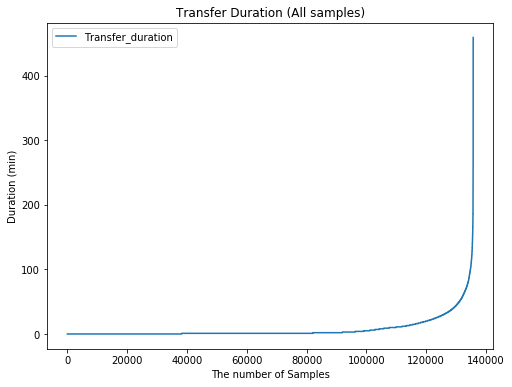

In [92]:
fig = plt.figure(figsize = (8, 6))
ax = plt.subplot(111)
x = range(len(plan_trans['Transfer_duration']))
y = plan_trans.Transfer_duration.tolist()
y.sort()

ax.plot(x, y, label = 'Transfer_duration')
ax.set_xlabel('The number of Samples')
ax.set_ylabel('Duration (min)')
ax.set_title('Transfer Duration (All samples)')
ax.legend()
plt.show()

## filter samples
#### 筛选出计划的患者序列，顺序没有发生变化的样本，也就是没有发生插队情况的样本

In [93]:
print(f'The number of all samples {plan_trans.shape}')

plan_trans['norm'] = plan_trans.order - plan_trans.last_order
plan_norm = plan_trans[plan_trans.norm == 1]
print(f'The number of samples order normal {plan_norm.shape}')

The number of all samples (135695, 37)
The number of samples order normal (47491, 38)


In [97]:
# 人工预测的基准
# 目前医院设置转换时长全部认为是0
# 全部样本，也就是包括了“插队”的情况
print(f'MAE all samples: {plan_trans.Transfer_duration.mean()}')

# 只包括本身就是相邻的两位患者的数据
print(f'MAE samples with normal orders: {plan_norm.Transfer_duration.mean()}')

MAE all samples: 7.644216809757176
MAE samples with normal orders: 8.413215135499359


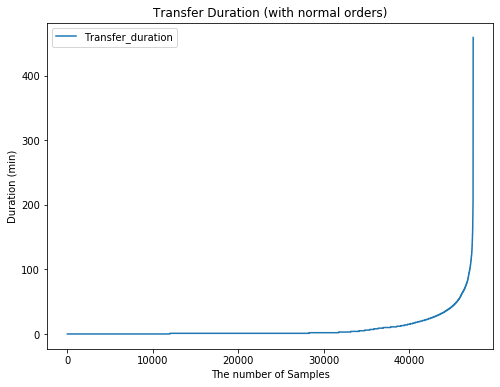

In [98]:
fig = plt.figure(figsize = (8, 6))
ax = plt.subplot(111)
x = range(len(plan_norm['Transfer_duration']))
y = plan_norm.Transfer_duration.tolist()
y.sort()

ax.plot(x, y, label = 'Transfer_duration')
ax.set_xlabel('The number of Samples')
ax.set_ylabel('Duration (min)')
ax.set_title('Transfer Duration (with normal orders)')
ax.legend()
plt.show()

# 3 Generate training samples

In [99]:
def MAE(pred_y, test_y):
    mae = sum(np.abs((pred_y - test_y))) / len(pred_y)
    return mae

In [100]:
def RMSE(pred_y, test_y):
    sq = sum((pred_y - test_y)**2) / len(pred_y)
#     sq = sum((pred_y - np.array(test_y.Actual_duration.tolist()))**2) / len(pred_y)
    rmse = np.sqrt(sq)
    return rmse

In [104]:
def generate_sample(room_sample_all):
    
    # 对分类变量进行one-hot encoding处理
    encode_cate = pd.DataFrame({})

    encode_cate['last_dxt_AliasName'] = room_sample_all['last_dxt_AliasName'].apply(
        lambda x: sum(label_encoder_dxt_AliasName.transform(np.array(x).reshape(-1,1))))
    train_x = np.vstack(encode_cate.last_dxt_AliasName.tolist())
    
    encode_cate['dxt_AliasName'] = room_sample_all['dxt_AliasName'].apply(
        lambda x: sum(label_encoder_dxt_AliasName.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.dxt_AliasName.tolist())))
    
    encode_cate['last_Sex'] = room_sample_all['last_Sex'].apply(
        lambda x: sum(label_encoder_Sex.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.last_Sex.tolist())))
    
    encode_cate['Sex'] = room_sample_all['Sex'].apply(
        lambda x: sum(label_encoder_Sex.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.Sex.tolist())))

    encode_cate['last_AliasSerNum'] = room_sample_all['last_AliasSerNum'].apply(
        lambda x: sum(label_encoder_AliasSerNum.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.last_AliasSerNum.tolist())))
    
    encode_cate['AliasSerNum'] = room_sample_all['AliasSerNum'].apply(
        lambda x: sum(label_encoder_AliasSerNum.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.AliasSerNum.tolist())))
    
    encode_cate['last_hour'] = room_sample_all['last_hour'].apply(
        lambda x: sum(label_encoder_hour.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.last_hour.tolist())))
    
    encode_cate['hour'] = room_sample_all['hour'].apply(
        lambda x: sum(label_encoder_hour.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.hour.tolist())))

    
    encode_cate['last_DoctorSerNum'] = room_sample_all['last_DoctorSerNum'].apply(
        lambda x: sum(label_encoder_DoctorSerNum.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.last_DoctorSerNum.tolist())))

    encode_cate['DoctorSerNum'] = room_sample_all['DoctorSerNum'].apply(
        lambda x: sum(label_encoder_DoctorSerNum.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.DoctorSerNum.tolist())))
    
    encode_cate['last_TreatmentOrientation'] = room_sample_all['last_TreatmentOrientation'].apply(
        lambda x: sum(label_encoder_TreatmentOrientation.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.last_TreatmentOrientation.tolist())))

    encode_cate['TreatmentOrientation'] = room_sample_all['TreatmentOrientation'].apply(
        lambda x: sum(label_encoder_TreatmentOrientation.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.TreatmentOrientation.tolist())))
    
    encode_cate['last_FractionNumber'] = room_sample_all['last_FractionNumber'].apply(
        lambda x: sum(label_encoder_FractionNumber.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.last_FractionNumber.tolist())))
    
    encode_cate['FractionNumber'] = room_sample_all['FractionNumber'].apply(
        lambda x: sum(label_encoder_FractionNumber.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.FractionNumber.tolist())))

    encode_cate['last_UserName'] = room_sample_all['last_UserName'].apply(
        lambda x: sum(label_encoder_UserName.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.last_UserName.tolist())))

    encode_cate['UserName'] = room_sample_all['UserName'].apply(
        lambda x: sum(label_encoder_UserName.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.UserName.tolist())))
    
    encode_cate['last_CourseId'] = room_sample_all['last_CourseId'].apply(
        lambda x: sum(label_encoder_CourseId.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.last_CourseId.tolist())))

    encode_cate['CourseId'] = room_sample_all['CourseId'].apply(
        lambda x: sum(label_encoder_CourseId.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.CourseId.tolist())))
    
    
    encode_cate['ResourceSerNum'] = room_sample_all['ResourceSerNum'].apply(
        lambda x: sum(label_encoder_ResourceSerNum.transform(np.array(str(x)).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.ResourceSerNum.tolist())))
    
    encode_cate['month'] = room_sample_all['month'].apply(
        lambda x: sum(label_encoder_month.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.month.tolist())))

    encode_cate['week'] = room_sample_all['week'].apply(
        lambda x: sum(label_encoder_week.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.week.tolist())))
    
    
    # encode_cate['AliasExpressionSerNum'] = room['AliasExpressionSerNum'].apply(
    #    lambda x: sum(label_encoder_AliasExpressionSerNum.transform(np.array(x).reshape(-1,1))))
    # train_x = np.hstack((train_x, np.vstack(encode_cate.AliasExpressionSerNum.tolist())))
    
    
    # 将数值变量和非数值变量进行合并
    train_num = room_sample_all[ROOM_NUM_FEATURES]
    train_num.drop('Transfer_duration', axis = 1, inplace = True)
    train_x = np.hstack((train_x, train_num))
    
    train_y = room_sample_all[['Transfer_duration']]
    
    return train_x, train_y

In [105]:
x_samples, y_labels = generate_sample(room_sample_all)

In [107]:
samples_length = len(y_labels)

train_x = x_samples[: int(samples_length * 0.9)]
train_y = y_labels[: int(samples_length * 0.9)]
print(f'The shape of train_x is {train_x.shape}')

val_x = x_samples[int(samples_length * 0.9): int(samples_length * 0.95)]
val_y = y_labels[int(samples_length * 0.9): int(samples_length * 0.95)]
print(f'The shape of val_x is {val_x.shape}')

test_x = x_samples[int(samples_length * 0.95): ]
test_y = y_labels[int(samples_length * 0.95): ]
print(f'The shape of test_x is {test_x.shape}')

The shape of train_x is (122125, 561)
The shape of val_x is (6785, 561)
The shape of test_x is (6785, 561)


In [108]:
# 创建模型，训练模型
print('='*40)
print('Train model')
gbm_room = lgb.LGBMRegressor(objective='mae', num_leaves=31, learning_rate=0.1,
                             n_estimators = 20000)#num_leaves=31

gbm_room.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (val_x, val_y)],
    eval_metric='mae',
    early_stopping_rounds=100,
    verbose=20
)

# verbose=200

Train model
Training until validation scores don't improve for 100 rounds
[20]	training's l1: 2.93314	valid_1's l1: 2.96835
[40]	training's l1: 2.17259	valid_1's l1: 2.19982
[60]	training's l1: 2.05038	valid_1's l1: 2.05744
[80]	training's l1: 2.04479	valid_1's l1: 2.04954
[100]	training's l1: 2.04479	valid_1's l1: 2.04953
[120]	training's l1: 2.04479	valid_1's l1: 2.04953
[140]	training's l1: 2.04479	valid_1's l1: 2.04953
[160]	training's l1: 2.04479	valid_1's l1: 2.04953
[180]	training's l1: 2.04479	valid_1's l1: 2.04953
[200]	training's l1: 2.04479	valid_1's l1: 2.04953
[220]	training's l1: 2.04479	valid_1's l1: 2.04953
[240]	training's l1: 2.04479	valid_1's l1: 2.04953
[260]	training's l1: 2.04479	valid_1's l1: 2.04953
[280]	training's l1: 2.04479	valid_1's l1: 2.04953
[300]	training's l1: 2.04479	valid_1's l1: 2.04953
[320]	training's l1: 2.04479	valid_1's l1: 2.04953
[340]	training's l1: 2.04479	valid_1's l1: 2.04953
[360]	training's l1: 2.04479	valid_1's l1: 2.04953
[380]	traini

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, num_leaves=31, objective='mae',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [109]:
# 测试
pred_y = gbm_room.predict(test_x, num_iteration = gbm_room.best_iteration_)

mae = MAE(pred_y, np.array(test_y.Transfer_duration.tolist()))
print(mae)

2.132696020237935


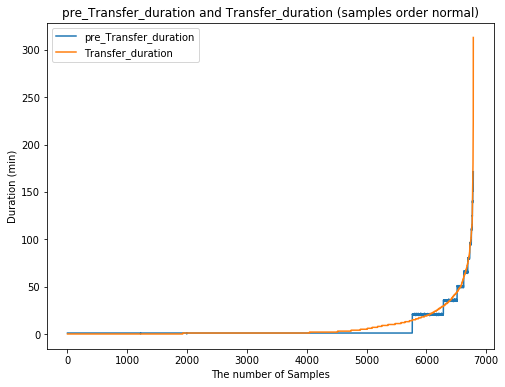

In [110]:
trans_pred_act = pd.DataFrame({'pre_Transfer_duration': pred_y,
                               'Transfer_duration': test_y.Transfer_duration.tolist()})
trans_pred_act.sort_values(by = ['Transfer_duration'], inplace = True)

fig = plt.figure(figsize = (8, 6))
ax = plt.subplot(111)
x = range(trans_pred_act.shape[0])
y1 = trans_pred_act.pre_Transfer_duration.tolist()
y2 = trans_pred_act.Transfer_duration.tolist()
ax.plot(x, y1, label = 'pre_Transfer_duration')
ax.plot(x, y2, label = 'Transfer_duration')

ax.set_xlabel('The number of Samples')
ax.set_ylabel('Duration (min)')
ax.set_title('pre_Transfer_duration and Transfer_duration (samples order normal)')
ax.legend()
plt.show()

In [ ]:
_